# Load and check data

In [16]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

import nltk
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import xgboost as xgb

In [26]:
# Load in the train and test datasets
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

full_data = [train, test]

train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
# Explore the dataset 
print("Number of rows in train dataset {}".format(train.shape[0]))
print("Number of rows in test dataset {}".format(test.shape[0]))
print("No duplicates in train data") if train.shape[
    0] == train.text.unique().__len__() else print("Oops")
print("No duplicates in test data") if test.shape[
    0] == test.text.unique().__len__() else print("Oops")
print("Unique author is data {}".format(train.author.unique()))
print("Number of nulls in the train is {} and text is {}".format(
    train.isnull().sum().sum(), test.isnull().sum().sum()))

Number of rows in train dataset 19579
Number of rows in test dataset 8392
No duplicates in train data
No duplicates in test data
Unique author is data ['EAP' 'HPL' 'MWS']
Number of nulls in the train is 0 and text is 0


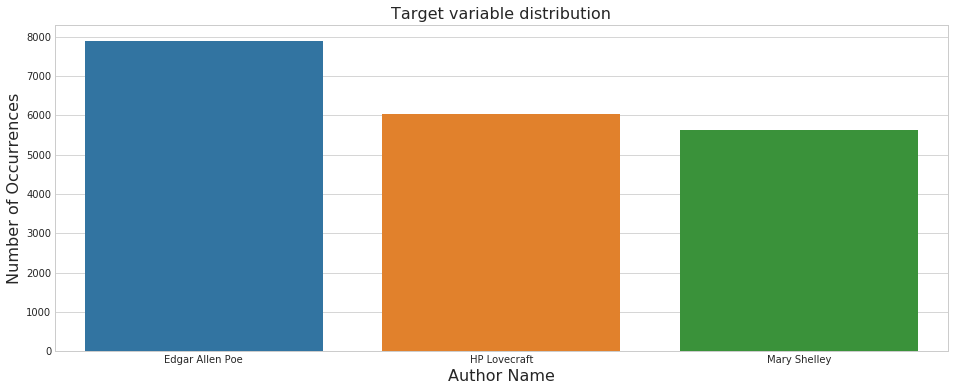

In [6]:
z = {'EAP': 'Edgar Allen Poe', 'MWS': 'Mary Shelley', 'HPL': 'HP Lovecraft'}
plt.figure(figsize=(16, 6))
plt.title('Target variable distribution', fontsize=16)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Author Name', fontsize=16)
sns.barplot(
    x=train.author.map(z).unique(), y=train.author.value_counts().values)

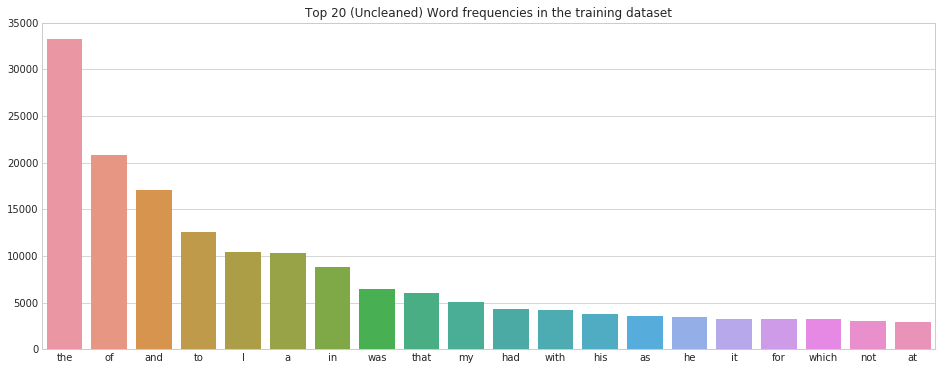

In [7]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()
plt.figure(figsize=(16, 6))
plt.title('Top 20 (Uncleaned) Word frequencies in the training dataset')
sns.barplot(x=all_words.index.values[:20], y=all_words.values[:20])

# Wordclouds

# Natural Language Processing

## Tokenization

In [8]:
# Storing the first text element as a string
first_text = train.text.values[0]
print(first_text)
print("="*90)
print(first_text.split(" "))

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
['This', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon;', 'as', 'I', 'might', 'make', 'its', 'circuit,', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out,', 'without', 'being', 'aware', 'of', 'the', 'fact;', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall.']


In [9]:
first_text_list = nltk.word_tokenize(first_text)
print(first_text_list)

['This', 'process', ',', 'however', ',', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the', 'dimensions', 'of', 'my', 'dungeon', ';', 'as', 'I', 'might', 'make', 'its', 'circuit', ',', 'and', 'return', 'to', 'the', 'point', 'whence', 'I', 'set', 'out', ',', 'without', 'being', 'aware', 'of', 'the', 'fact', ';', 'so', 'perfectly', 'uniform', 'seemed', 'the', 'wall', '.']


## Stopword Removal

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

153

In [11]:
first_text_list_cleaned = [
    word for word in first_text_list if word.lower() not in stopwords
]
print(first_text_list_cleaned)
print("=" * 90)
print("Length of original list: {} words\n"
      "Length of list after stopwords removal: {} words".format(
          len(first_text_list), len(first_text_list_cleaned)))

['process', ',', 'however', ',', 'afforded', 'means', 'ascertaining', 'dimensions', 'dungeon', ';', 'might', 'make', 'circuit', ',', 'return', 'point', 'whence', 'set', ',', 'without', 'aware', 'fact', ';', 'perfectly', 'uniform', 'seemed', 'wall', '.']
Length of original list: 48 words
Length of list after stopwords removal: 28 words


## Stemming and Lemmatization

In [13]:
stemmer = nltk.stem.PorterStemmer()
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run
The stemmed form of leaves is: leav


In [14]:
lemm =  nltk.stem.WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is: leaf


## Vectorizing Raw Text

In [15]:
# Defining our sentence
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try CountVectorizer
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


In [17]:
sentence = ["I love to eat Burgers", "I love to eat Fries"]
# try  TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(
    sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[ 0.63009934  0.44832087  0.          0.44832087  0.44832087]
 [ 0.          0.44832087  0.63009934  0.44832087  0.44832087]]


# Feature Engineering

## some features

In [28]:
# word count
def word_count(raw):
    return len(raw['text'].split())


for dataset in full_data:
    dataset['word_count'] = dataset.apply(lambda raw: word_count(raw), axis=1)

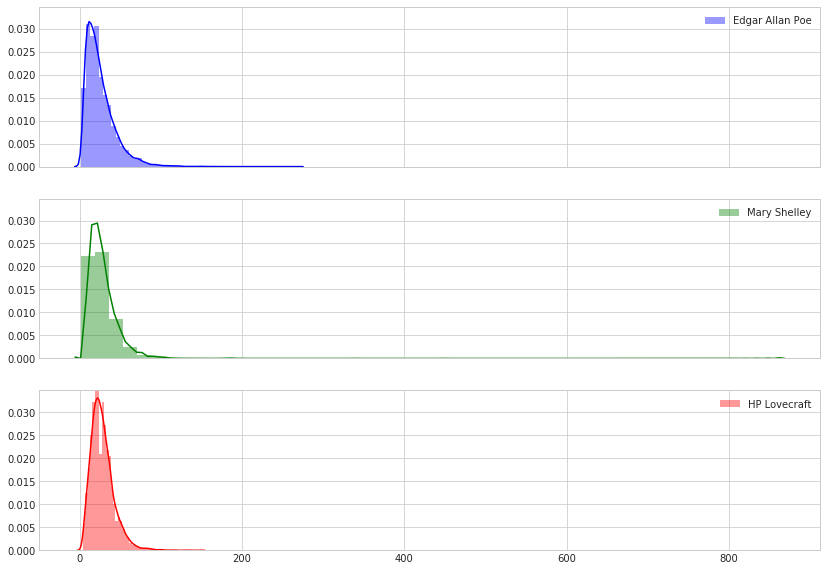

In [33]:
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(14, 10))
sns.distplot(
    train.loc[train['author'] == 'EAP']['word_count'].values,
    ax=ax[0],
    color='blue',
    label='Edgar Allan Poe')
sns.distplot(
    train.loc[train['author'] == 'MWS']['word_count'].values,
    ax=ax[1],
    color='green',
    label='Mary Shelley')
sns.distplot(
    train.loc[train['author'] == 'HPL']['word_count'].values,
    ax=ax[2],
    color='red',
    label='HP Lovecraft')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
ax[2].legend(loc=0)

In [37]:
train.head()

,id,text,author,word_count
0,id26305,"This process, however, afforded me no means of...",EAP,41
1,id17569,It never once occurred to me that the fumbling...,HPL,14
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27


## Tf-idf features

In [25]:
lemm = WordNetLemmatizer()
class LemmCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [27]:
# Storing the entire training text in a list
text = list(train.text.values)
# Calling our overwritten Count vectorizer
tf_vectorizer = LemmCountVectorizer(
    max_df=0.95, min_df=2, stop_words='english', decode_error='ignore')
tf_train = tf_vectorizer.fit_transform(text)
tf_test = tf_vectorizer.transform(text)

In [19]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
full_tfidf = tfidf_vectorizer.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vectorizer.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vectorizer.transform(test_df['text'].values.tolist())

In [21]:
n_comp = 400
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)

In [24]:
drop_elements = ['id', 'text']
x_train = train_df.drop(drop_elements+['author'], axis=1)
x_test = test_df.drop(drop_elements, axis=1)

In [27]:
author_mapping_dict = {'EAP': 0, 'HPL': 1, 'MWS': 2}
y_train = train_df['author'].map(author_mapping_dict)
drop_elements = ['id', 'text']
x_train = train_df.drop(drop_elements+['author'], axis=1)
x_test = test_df.drop(drop_elements, axis=1)

## sentiment features

# Visualisations

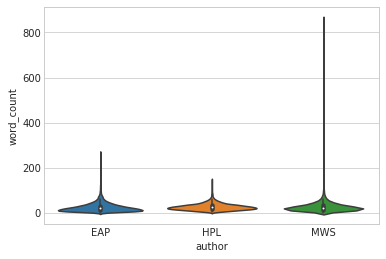

In [39]:
sns.violinplot(x = 'author', y='word_count', data=train)

# Ensembling & Stacking models

In [28]:
from sklearn.model_selection import train_test_split
xtr, xv, ytr, yv = train_test_split(
    x_train.values, y_train, test_size=0.2, random_state=1987)
dtrain = xgb.DMatrix(xtr, label=ytr)
dvalid = xgb.DMatrix(xv, label=yv)
dtest = xgb.DMatrix(test_X.values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgb_par = {
    'min_child_weight': 1,
    'eta': 0.1,
    'colsample_bytree': 0.7,
    'max_depth': 3,
    'subsample': 0.8,
    'lambda': 2.0,
    'nthread': -1,
    'silent': 1,
    'eval_metric': "mlogloss",
    'objective': 'multi:softprob',
    'num_class': 3
}

model_1 = xgb.train(
    xgb_par,
    dtrain,
    1000,
    watchlist,
    early_stopping_rounds=50,
    maximize=False,
    verbose_eval=40)
print('Modeling RMSLE %.5f' % model_1.best_score)

[0]	train-mlogloss:1.07908	valid-mlogloss:1.08099
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.8139	valid-mlogloss:0.850742
[80]	train-mlogloss:0.733194	valid-mlogloss:0.80073
[120]	train-mlogloss:0.677019	valid-mlogloss:0.769391
[160]	train-mlogloss:0.632259	valid-mlogloss:0.747799
[200]	train-mlogloss:0.594561	valid-mlogloss:0.731481
[240]	train-mlogloss:0.5625	valid-mlogloss:0.718198
[280]	train-mlogloss:0.534187	valid-mlogloss:0.708329
[320]	train-mlogloss:0.508837	valid-mlogloss:0.700673
[360]	train-mlogloss:0.486059	valid-mlogloss:0.693733
[400]	train-mlogloss:0.46472	valid-mlogloss:0.687603
[440]	train-mlogloss:0.444816	valid-mlogloss:0.683617
[480]	train-mlogloss:0.426283	valid-mlogloss:0.679644
[520]	train-mlogloss:0.409511	valid-mlogloss:0.674964
[560]	train-mlogloss:0.392947	valid-mlogloss:0.671667
[600]	train-mlogloss:0.377694	valid-mlogloss:0.66

In [29]:
yvalid = model_1.predict(dvalid)
ytest = model_1.predict(dtest)

In [31]:
if test_df.shape[0] == ytest.shape[0]:
    print('Test shape OK.') 
test_id = test_df['id'].values
out_df = pd.DataFrame(ytest)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("../result/submission-20171121-01.csv", index=False)

Test shape OK.
